In [2]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model
import time
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import math
import os

from scipy import ndimage
import pandas as pd

In [5]:
def generate_scores(x, seed=None):
    np.random.seed(seed)
    d = x.shape[1]
    rng = np.random.default_rng(seed)
    term1 = x.dot(np.random.uniform(low=-1, high=1, size=(d)))
    term2 = np.sum(np.multiply(x, rng.permutation(x, 1)), 1)
    term3 = np.sum(np.multiply(np.multiply(x, rng.permutation(x, 1)), rng.permutation(x, 1)), 1)
    # normalize
    term1 = (term1 - np.mean(term1)) / np.std(term1)
    term2 = (term2 - np.mean(term2)) / np.std(term2)
    term3 = (term3 - np.mean(term3)) / np.std(term3)
    scores = (term1 + term2 + term3) / 3
    scores = (term1 + term2) / 2
    scores = np.digitize(scores, bins = np.array([-1, -0.5, 0, 0.5, 1]), right=False)
    return np.clip(np.round(scores), 0., 5.).astype(np.float32)

# generate data
# split is based on queries, each query are either kept for training/testing only
def generate_data(data, doc_per_query):
    np.random.seed(seed)
    query = np.repeat(np.arange(nb_query)+1, np.ceil(np.abs(np.random.normal(mean_doc_per_query, size=nb_query, scale=0.15*mean_doc_per_query))+2).astype(np.int))
    doc_features = np.random.uniform(low=-1, high=1, size=(len(query), features)) # np.random.random((len(query), 10))
    doc_scores = generate_scores(doc_features, seed=seed) # np.random.randint(5, size=len(query)).astype(np.float32)

    # put data into pairs
    pair_id_train = []
    pair_id_test = []
    pair_query_id_train = []
    pair_query_id_test = []
    for q in np.unique(query):
        query_idx = np.where(query == q)[0]
        if np.random.random() < test_size:
            for pair_idx in combinations(query_idx, 2):
                pair_query_id_test.append(q)
                pair_id_test.append(pair_idx)
        else:
            for pair_idx in combinations(query_idx, 2):
                pair_query_id_train.append(q)
                pair_id_train.append(pair_idx)

    pair_id_train = np.array(pair_id_train)
    pair_id_test = np.array(pair_id_test)
    pair_query_id_train = np.array(pair_query_id_train)
    pair_query_id_test = np.array(pair_query_id_test)

    return query, doc_features, doc_scores, pair_id_train, pair_id_test, pair_query_id_train, pair_query_id_test

def generate_data_better(data, test_size):
    query = data.query_id
    doc_features = data[data.columns[2:]]
    doc_scores = data['rank']  # np.random.randint(5, size=len(query)).astype(np.float32)

    # put data into pairs
    pair_id_train = []
    pair_id_test = []
    pair_query_id_train = []
    pair_query_id_test = []
    for q in np.unique(query):
        query_idx = np.where(query == q)[0]
        if np.random.random() < test_size:
            for pair_idx in combinations(query_idx, 2):
                pair_query_id_test.append(q)
                pair_id_test.append(pair_idx)
        else:
            for pair_idx in combinations(query_idx, 2):
                pair_query_id_train.append(q)
                pair_id_train.append(pair_idx)

    pair_id_train = np.array(pair_id_train)
    pair_id_test = np.array(pair_id_test)
    pair_query_id_train = np.array(pair_query_id_train)
    pair_query_id_test = np.array(pair_query_id_test)

    return query, doc_features, doc_scores, pair_id_train, pair_id_test, pair_query_id_train, pair_query_id_test

test_size=.2
dir_path = '/home/darya/Загрузки'
data = pd.read_csv(os.path.join(dir_path, 'intern_task.csv'))

In [6]:
new_data = data.drop(columns = ['feature_8', 'feature_100', 'feature_65', 'feature_20', 'feature_35', 'feature_64', 'feature_72'])
query, doc_features, doc_scores, pair_id_train, pair_id_test, pair_query_id_train, pair_query_id_test = generate_data_better(data, test_size)
doc_features = doc_features.to_numpy()
query = query.to_numpy()
doc_scores = doc_scores.to_numpy()

# Imports and plots

In [7]:
def plot_metrics(train_metric, val_metric=None, metric_name1=None, metric_name12=None, title=None, ylim=5, ylim_low=0):
    plt.title(title)
    plt.ylim(ylim_low,ylim)
    plt.plot(train_metric, color='blue',label=metric_name1)
    if val_metric is not None: plt.plot(val_metric,color='green',label=metric_name12)
    plt.legend(loc="upper right")
    plt.show()

In [8]:
def get_data(query_id, pair_id, pair_query_id, query, doc_features, doc_scores):
    if type(query_id) is not np.ndarray:
        query_id = np.array([query_id]).ravel()
    _ind = np.hstack([np.where(query==i) for i in query_id]).ravel()

    q_unique, q_index, q_cnt  = np.unique(query, return_index=True, return_counts=True)
    doc_cnt = q_cnt[np.searchsorted(q_unique, query_id)].sum()
    x = doc_features[_ind]
    score = doc_scores[_ind]

    mask = np.zeros((doc_cnt, doc_cnt), dtype=np.float32)
    _, new_q_index = np.unique(query[_ind], return_index=True)
    _pair_id = np.vstack([pair_id[np.where(pair_query_id==i)] - q_index[q_unique==i] + new_q_index[query_id==i] for i in query_id])
    mask[_pair_id[:,0], _pair_id[:,1]] = 1

    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(score, dtype=tf.float32), tf.convert_to_tensor(mask, dtype=tf.float32), tf.convert_to_tensor(doc_cnt, dtype=tf.float32)

## factorised_ranknet

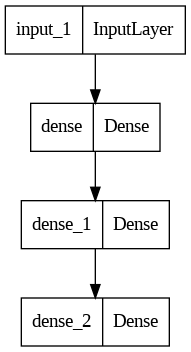

In [9]:
class FactorisedRankNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')

    def call(self, inputs):
        xi = inputs
        densei = self.dense[0](xi)
        for dense in self.dense[1:]:
            densei = dense(densei)
        oi = self.o(densei)
        return oi

    def build_graph(self):
        x = tf.keras.Input(shape=(10))
        return tf.keras.Model(inputs=x, outputs=self.call(x))

tf.keras.utils.plot_model(FactorisedRankNet().build_graph(), show_shapes=False)

## ndcg

In [10]:
def eval_ndcg(score, score_pred, return_ndcg_delta=False, eval_at=tf.Variable([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])):
    """
    calculates ndcg
    input should be documents' score of ONE query only
    """
    argsort_score = tf.argsort(score, direction='DESCENDING')
    argsort_score_pred = tf.argsort(score_pred, direction='DESCENDING')
    rank_plus_one = tf.dtypes.cast(tf.add(tf.argsort(argsort_score), 2), tf.float32)
    rank_plus_one_pred = tf.dtypes.cast(tf.add(tf.argsort(argsort_score_pred), 2), tf.float32)

    numerator = tf.subtract(tf.pow(2., score), 1)
    idcg_denominator = tf.experimental.numpy.log2(rank_plus_one)
    dcg_denominator = tf.experimental.numpy.log2(rank_plus_one_pred)
    idcg = tf.divide(numerator, idcg_denominator)
    dcg = tf.divide(numerator, dcg_denominator)

    # calculate ndcg_delta if i and j swapped position
    if return_ndcg_delta is True:
        # numerator_{ij} = 2^{rel_{i}} - 2^{rel_{j}}
        numerator_ij = tf.subtract(tf.expand_dims(numerator, -1), numerator)
        # dcg_denominator_{ij} = \frac{1}{log(Rank_{i}+1)} - \frac{1}{log(Rank_{j}+1)}
        dcg_denominator_ij = tf.subtract(tf.expand_dims(dcg_denominator, -1), dcg_denominator)
        # ndcg_delta_ij = absolute change in ndcg is i and j swapped position
        ndcg_delta_ij = tf.abs(tf.divide(tf.multiply(numerator_ij, dcg_denominator_ij), tf.maximum(tf.reduce_sum(idcg), 0.001)))

    # calculate ndcg@all
    ndcg = tf.TensorArray(tf.float32, size=tf.shape(eval_at)[0]+1)
    ndcg = ndcg.write(0, tf.divide(tf.reduce_sum(dcg), tf.maximum(tf.reduce_sum(idcg), 0.001)))

    # calculate ndcg@k per eval_at position
    if eval_at is not None:
        idcg = tf.gather(idcg, argsort_score)
        dcg = tf.gather(dcg, argsort_score_pred)

        def ndcg_at_k(i, ndcg):
            k = eval_at[i]
            ndcg = ndcg.write(i+1, tf.divide(tf.reduce_sum(dcg[:k]), tf.maximum(tf.reduce_sum(idcg[:k]), 0.001)))
            return (tf.add(i, 1), ndcg)

        i = tf.constant(0)
        _, ndcg = tf.while_loop(lambda i, _: tf.less(i, tf.shape(eval_at)[0]), ndcg_at_k, [i, ndcg])

    if return_ndcg_delta is True:
        return ndcg.stack(), ndcg_delta_ij
    else:
        return ndcg.stack()

## gradient

In [11]:
def apply_gradient_lambdarank(optimizer, model, x, score, mask, doc_cnt, eval_ndcg=eval_ndcg):
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        oi = model(x)

    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    lambda_ij = tf.add(tf.negative(P_ij), P_ij_pred)

    ndcg, ndcg_delta_ij = eval_ndcg(score, tf.squeeze(oi, 1), return_ndcg_delta=True)
    lambda_ij = tf.multiply(lambda_ij, ndcg_delta_ij)

    lambda_i = tf.reduce_sum(lambda_ij,1) - tf.reduce_sum(lambda_ij,0)

    doi_dwk = tape.jacobian(oi, model.trainable_weights)

    # 1. reshape lambda_i to match the rank of the corresponding doi_dwk
    # 2. multiple reshaped lambda_i with the corresponding doi_dwk
    # 3. compute the sum across first 2 dimensions
    gradients = list(map(lambda k:
                         tf.reduce_sum(tf.multiply(tf.reshape(lambda_i,  tf.concat([tf.shape(lambda_i),tf.ones(tf.rank(k) - 1, dtype=tf.int32)], axis=-1)), k), [0,1]),
                         doi_dwk))

    # model could still be trained without calculating the loss below
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.multiply(loss_value, doc_cnt)

    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return oi, loss_value, ndcg


In [12]:
def apply_gradient_factorised(optimizer, model, x, score, mask, doc_cnt):
    with tf.GradientTape() as tape:
        oi = model(x)

    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    lambda_ij = tf.add(tf.negative(P_ij), P_ij_pred)
    lambda_i = tf.reduce_sum(lambda_ij,1) - tf.reduce_sum(lambda_ij,0)

    doi_dwk = tape.jacobian(oi, model.trainable_weights)

    # 1. reshape lambda_i to match the rank of the corresponding doi_dwk
    # 2. multiple reshaped lambda_i with the corresponding doi_dwk
    # 3. compute the sum across first 2 dimensions
    gradients = list(map(lambda k:
                         tf.reduce_sum(tf.multiply(tf.reshape(lambda_i,  tf.concat([tf.shape(lambda_i),tf.ones(tf.rank(k) - 1, dtype=tf.int32)], axis=-1)), k), [0,1]),
                         doi_dwk))

    # model could still be trained without calculating the loss below
    valid_pair_cnt = tf.reduce_sum(mask)
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.multiply(loss_value, doc_cnt)

    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return oi, loss_value

## train

In [13]:
def train_data_for_one_epoch_lambdarank(optimizer, model, pair_query_id_train, pair_id_train, apply_gradient=apply_gradient_factorised,
                                        eval_ndcg=eval_ndcg):
    losses = []
    losses_ndcg = []

    pb_i = Progbar(np.ceil(len(np.unique(pair_query_id_train)) // 1), stateful_metrics=['loss'])
    _query = np.unique(pair_query_id_train)
    np.random.shuffle(_query)
    for step, query_id in enumerate(_query):
        x, score, mask, doc_cnt = get_data(query_id, pair_id_train, pair_query_id_train, query, doc_features, doc_scores)
        y_pred, loss_value, ndcg_value = apply_gradient(optimizer, model, x, score, mask, doc_cnt, eval_ndcg)
        losses.append(loss_value)
        losses_ndcg.append(ndcg_value)

        pb_i.add(1)
    return losses, losses_ndcg

## val

In [14]:
def validate_data_for_one_epoch(model, compute_val_loss, eval_ndcg, pair_id_test, pair_query_id_test):
    losses = []
    losses_ndcg = []

    _query_ids = np.unique(pair_query_id_test)
    for step, query_id in enumerate(_query_ids):
        x, score, mask, doc_cnt = get_data(query_id, pair_id_test, pair_query_id_test, query, doc_features, doc_scores)
        loss_value, ndcg_value = compute_val_loss(model, x, score, mask, doc_cnt, eval_ndcg)
        losses.append(loss_value)
        losses_ndcg.append(ndcg_value)

    return losses, losses_ndcg

def compute_val_loss(model, x, score, mask, doc_cnt, eval_ndcg):
    oi = model(x)
    S_ij = tf.maximum(tf.minimum(tf.subtract(tf.expand_dims(score,1), score),1.),-1.)
    P_ij = tf.multiply(mask, tf.multiply(0.5, tf.add(1., S_ij)))
    P_ij_pred = tf.multiply(mask,tf.nn.sigmoid(tf.subtract(oi, tf.transpose(oi))))
    loss_value = tf.reduce_sum(tf.keras.losses.binary_crossentropy(P_ij, P_ij_pred))
    loss_value = tf.multiply(loss_value, doc_cnt)

    ndcg = eval_ndcg(score, tf.squeeze(oi, 1))

    return loss_value, ndcg

# Train loop

Epoch 1/1000
1601/1601 [==============================] - 63s 33ms/step
Loss Train: 6.3506  Validation: 6.7233 | NDCG Train 0.5848  NDCG Validation 0.5800
Epoch 2/1000
1601/1601 [==============================] - 52s 32ms/step
Loss Train: 6.6126  Validation: 6.1710 | NDCG Train 0.5944  NDCG Validation 0.6037
Epoch 3/1000
1601/1601 [==============================] - 51s 32ms/step
Loss Train: 6.4448  Validation: 6.6601 | NDCG Train 0.5977  NDCG Validation 0.5743
Epoch 4/1000
1601/1601 [==============================] - 52s 32ms/step
Loss Train: 6.2416  Validation: 6.4577 | NDCG Train 0.5946  NDCG Validation 0.5715
Epoch 5/1000
1601/1601 [==============================] - 53s 33ms/step
Loss Train: 5.7495  Validation: 6.2128 | NDCG Train 0.5977  NDCG Validation 0.5864
Epoch 6/1000
1601/1601 [==============================] - 54s 33ms/step
Loss Train: 6.0910  Validation: 5.9227 | NDCG Train 0.5948  NDCG Validation 0.5952
Epoch 7/1000
1601/1601 [==============================] - 52s 32ms/ste

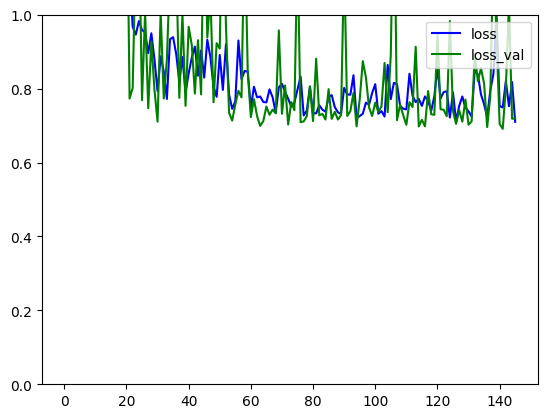

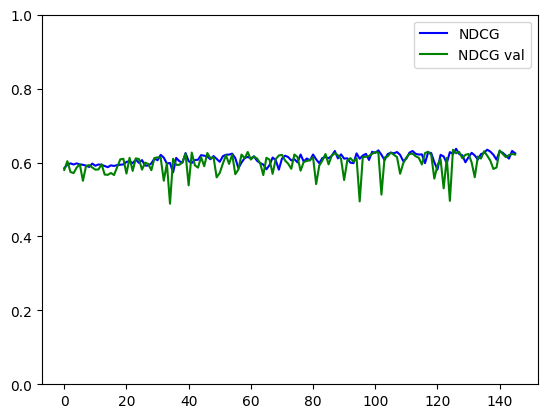

took 8216.78 seconds


In [15]:
time_start = time.perf_counter()

# init optimizer
optimizer = tf.keras.optimizers.Adam()

# start training
fac_ranknet = FactorisedRankNet()

epochs = 1000
early_stop_patience = 100
loss_train_history = []
ndcg_train_history_lr = []
loss_val_history = []
ndcg_val_history_lr = []

apply_gradient_graph = tf.function(apply_gradient_lambdarank, reduce_retracing=True) # experimental_relax_shapes -> reduce_retracing bcs ersh depricated
eval_ndcg_graph = tf.function(eval_ndcg)
compute_val_loss_graph = tf.function(compute_val_loss, reduce_retracing=True) # experimental_relax_shapes -> reduce_retracing bcs ersh depricated

for epoch in range(epochs):
    print('Epoch %d/%d'%(epoch+1, epochs))
    losses_train, ndcg_train = train_data_for_one_epoch_lambdarank(optimizer, fac_ranknet, pair_query_id_train, pair_id_train, apply_gradient=apply_gradient_graph, eval_ndcg=eval_ndcg_graph)
    loss_train_history.append(np.sum(losses_train)/pair_id_train.shape[0])
    ndcg_train_history_lr.append(np.mean(ndcg_train, 0))

    losses_val, ndcg_val = validate_data_for_one_epoch(fac_ranknet, compute_val_loss_graph, eval_ndcg_graph, pair_id_test, pair_query_id_test)
    loss_val_history.append(np.sum(losses_val)/pair_id_test.shape[0])
    ndcg_val_history_lr.append(np.mean(ndcg_val, 0))
    print('Loss Train: %.4f  Validation: %.4f | NDCG Train %.4f  NDCG Validation %.4f' % (float(loss_train_history[-1]), float(loss_val_history[-1]), float(ndcg_train_history_lr[-1][0]), float(ndcg_val_history_lr[-1][0])))

    if len(ndcg_val_history_lr) > early_stop_patience:
        _best = np.max(np.array(ndcg_val_history_lr[-20:])[:,0])
        if ndcg_val_history_lr[-21][0] > _best:
            print('Early stopped')
            print(_best)
            print(ndcg_val_history_lr[-21][0]) # ndcg_val_history -> ndcg_val_history_lr
            break


plot_metrics(loss_train_history, loss_val_history, 'loss', 'loss_val', ylim=1.0)

ndcg_train_history_lr = np.array(ndcg_train_history_lr)
ndcg_val_history_lr = np.array(ndcg_val_history_lr)
plot_metrics(ndcg_train_history_lr[:,0], ndcg_val_history_lr[:,0], 'NDCG', 'NDCG val', ylim=1.0)

print('took %.2f seconds' % (time.perf_counter() - time_start))